Here a sensitivity test is performed with the aim of figuring out what values of lex, sal, Tsur and rho that would fit as good start guesses

In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
from smrt import SMRTError
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions import forward_mean, forward_OIB
from prepare_inputs_OE import prepare_inputs, prepare_inputs_FYI
import prepare_inputs_OE as piO

In [2]:
def SMRT_simulation(self):
    ## Make icepack           
    sea_ice_density = 900
    icepack = make_ice_column(ice_type='firstyear',
            thickness=[self.sit], 
            temperature=[self.T_sii], 
            microstructure_model='exponential',
            corr_length=[self.sit_lex],
            brine_inclusion_shape='spheres',
            density=sea_ice_density,
            salinity=[self.sit_sal],
            add_water_substrate="ocean")

    snowpack = make_snowpack(self.sd, 
                    microstructure_model='exponential',
                    ice_permittivity_model=ssp, 
                    density=self.rho, 
                    corr_length=self.lex, 
                    temperature = self.Tsnow,
                    salinity=self.sal)

    
    medium = snowpack + icepack
    
    
    m = make_model("iba", "dort")
    
    frequencies= [6.925e9] #np.array([6.925e9]) # ,10.65e9,18.7e9,23.8e9,36.5e9]);  # [Hz]
    
    beamorientation = 55. # [degrees]
    sensor = sensor_list.passive(frequencies, beamorientation)
    
    #% Run simulations
    res = m.run(sensor, medium)
    
    # #% adjust for atmospheric influence
    m = self.m

    [TB_AMSR_V,TB_AMSR_H, Gamma_rs_H, Gamma_rs_V, QH, QV] = roughness(self.tcwv,res,self.T_sii, m=m)
    [TB_AMSR_V,TB_AMSR_H] = [res.TbV(),res.TbH()]
    if self.pol=='V':
        return TB_AMSR_V 
    else:
        return [TB_AMSR_V,TB_AMSR_H]


In [3]:
FYI_data = piO.OIB_data('FYI', new=False)

FYI_OIB_SIM = np.concatenate([np.mean(FYI_data.TbV_sim, axis=0), np.mean(FYI_data.TbH_sim, axis=0)])
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])
FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])



Starting point based on values from CB. Focus on vertical polarization

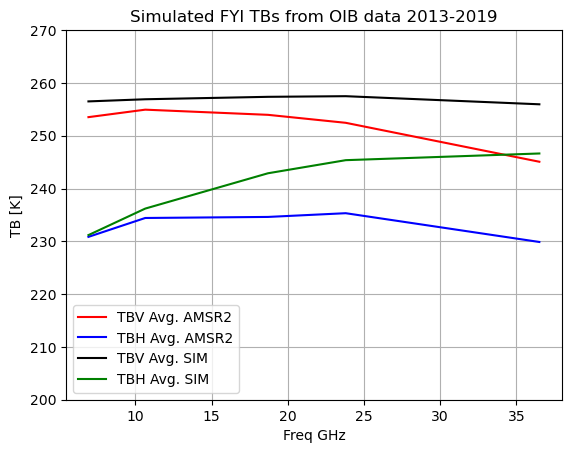

In [4]:
## Plots results
#plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = FYI_OIB_SIM[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
y = FYI_OIB_SIM[5:]
plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

In [5]:
## OIB/CB VALUES
print('lex: ', np.mean(FYI_data.sd_lex, axis=0)*1e3)
print('rho: ', np.mean(FYI_data.sd_rho, axis=0))
print('sal: ', np.mean(FYI_data.sd_sal, axis=0)*1e3)
print('SD:', np.mean(FYI_data.sd, axis=0))
print('SIT:', np.mean(FYI_data.sit))

lex:  [0.14013647 0.16445789]
rho:  [348.53339933 337.51818972]
sal:  [0.88802032 8.67319838]
SD: [0.10567324 0.03      ]
SIT: 1.4398281690140846


Values not changing:
SD, SIT

In [6]:
class smrt_values():
    # init method or constructor
    def __init__(self, OIB_data):
        #
        self.pol = 'both'
        self.Tsur = np.mean(OIB_data.skt)
        self.m = 0.08 # roughness variable
        self.tcwv = np.mean(OIB_data.tcwv) #total columnar water vapour
        self.ks = 0.25
        # Snow variables
        sd_tot = np.mean(np.sum(OIB_data.sd, axis=1))
        sd0 = sd_tot - 0.03
        sd1 = 0.03
        self.sd = [sd0, sd1]
        self.lex = np.mean(OIB_data.sd_lex, axis=0)
        self.sal = np.mean(OIB_data.sd_sal, axis=0)
        self.rho = np.mean(OIB_data.sd_rho, axis=0)
        # Ice varibles
        self.sit = np.mean(OIB_data.sit)
        self.sit_lex = 0.15e-3
        self.sit_sal = 7*PSU
        # Temperatures
    def calc_temp(self, plot=True):
        k = 2.10 # thermal conductivity FYI
        T_w = (273.15-1.8)  # Ocean temperature [K]
        ks = self.ks # Thermal conductivity of snow [w/(m*K)]

        ## snow ice interface temperature
        self.T_sii = (k * np.sum(self.sd) * T_w + ks * self.sit *
                    self.Tsur) / (k * np.sum(self.sd) + ks * self.sit)

        x = [0, np.sum(self.sd)]
        y = [self.Tsur, self.T_sii]
        model = LinearRegression().fit(np.array(x).reshape(-1,1), np.array(y))
        xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2]).reshape(-1,1)
        self.Tsnow = model.predict(xx)
        
        #if plot==True:
        # ice/snow thickness arrays for showing temperature profiles    
        ice_thick = np.array([0, -self.sit])
        t_ice = np.array([self.T_sii, T_w])
        
        #snow_thick = [np.sum(self.sd), self.sd[0]/2 + self.sd[1], self.sd[1]/2, 0]
        #t_snow = [self.Tsur] + [Ts for Ts in self.Tsnow] + [self.T_sii]

        if plot==True:
            plt.figure()
            plt.plot(t_snow, snow_thick,'.-')
            plt.plot(t_ice, ice_thick,'.-')
            plt.grid()
            plt.xlabel('Temperature [K]')
            plt.ylabel('Depth [m]')
            

-------------------------------------------------------------
SD :0.02
rv [0.06098733 0.05977312 0.05755904 0.05429391 0.04990544 0.04430437
 0.03739857 0.02913436 0.01961577 0.00947229 0.00116165 0.00499259
 0.09090423]
mu1: [ 3.54305728  8.14700152 12.81279029 17.5417546  22.35608312 27.28651631
 32.37397683 37.67510445 43.27322873 49.30144305 55.99897078 63.88857508
 74.7361727 ]
mu2: [ 2.13620103  4.90347272  7.68708659 10.47439279 13.2630995  16.05248384
 18.84224678 21.63224247 24.42239134 27.2126463  30.00297771 32.79336598
 35.58379763]
mu1: [0.99808864 0.98990774 0.97509987 0.95349756 0.92483785 0.88872514
 0.84457121 0.79148917 0.72809312 0.65207931 0.5592078  0.44011823
 0.26326404]
mu2: [0.99930504 0.99634012 0.99101337 0.98333626 0.97332683 0.9610088
 0.94641138 0.92956918 0.91052215 0.88931546 0.86599942 0.84062932
 0.81326534]
eps1: (1.2435222735603593+0.015939372724678776j)
eps2: (3.418026450027469+0.04245279035058225j)
V---------------------
[0.93901267 0.94022688 0.94

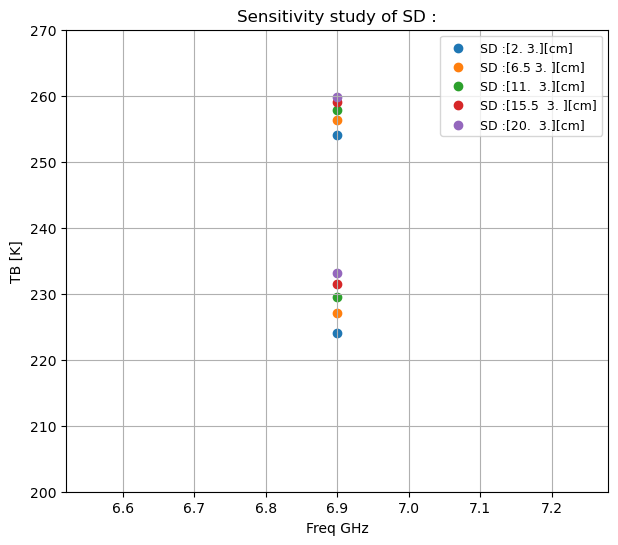

-------------------------------------------------------------
ks :0.1
-------------------------------------------------------------
ks :0.1875
-------------------------------------------------------------
ks :0.275
rv [0.06193802 0.06069968 0.05844122 0.05510972 0.05063038 0.04491063
 0.03785472 0.02940669 0.01967591 0.0093285  0.0009966  0.00597421
 0.10632318]
mu1: [ 3.55763851  8.18071593 12.86635438 17.61620985 22.4529697  27.40806065
 32.52340007 37.8571758  43.49534603 49.57601089 56.34968611 64.37322495
 75.6244014 ]
mu2: [ 2.13620116  4.903473    7.68708704 10.47439341 13.26310029 16.05248482
 18.84224795 21.63224385 24.42239294 27.21264814 30.00297983 32.7933684
 35.58380039]
mu1: [0.99807288 0.98982418 0.97489212 0.95310508 0.92419334 0.88775063
 0.84317194 0.789543   0.72543028 0.64843869 0.55412276 0.43250714
 0.24827736]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94641138 0.92956917 0.91052214 0.88931545 0.8659994  0.8406293
 0.81326532]
eps1

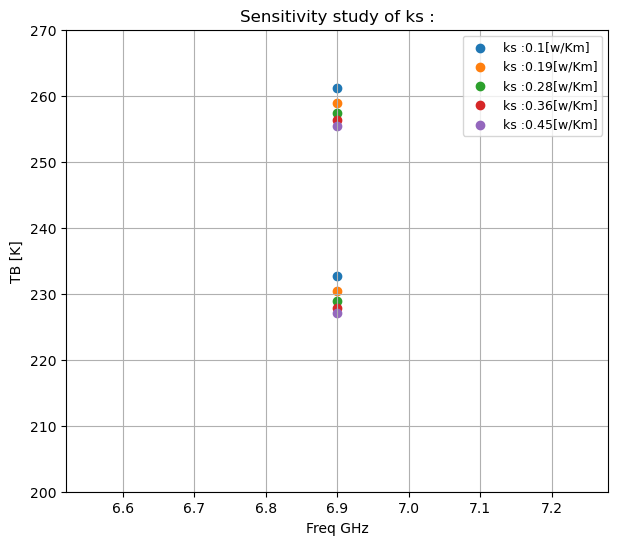

-------------------------------------------------------------
lex0 :5e-05
rv [0.06212484 0.06088174 0.05861453 0.05526993 0.05077265 0.04502946
 0.03794388 0.0294595  0.01968677 0.00929927 0.00096489 0.00618352
 0.10971789]
mu1: [ 3.56049941  8.18733111 12.87686513 17.63082175 22.47198702 27.43192362
 32.5527464  37.89295138 43.53902181 49.63006303 56.41887602 64.4693197
 75.80504879]
mu2: [ 2.13620114  4.90347296  7.68708696 10.47439331 13.26310016 16.05248465
 18.84224776 21.63224362 24.42239267 27.21264784 30.00297948 32.793368
 35.58379993]
mu1: [0.99806978 0.98980774 0.97485126 0.95302787 0.92406652 0.88755884
 0.84289645 0.78915965 0.72490539 0.64772023 0.55311711 0.43099434
 0.24522196]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94641138 0.92956917 0.91052214 0.88931545 0.8659994  0.8406293
 0.81326532]
eps1: (1.2558465956229954+0.01724856436252578j)
eps2: (3.485902483144466+0.048482768955471656j)
V---------------------
[0.93787516 0.93911826 0.941

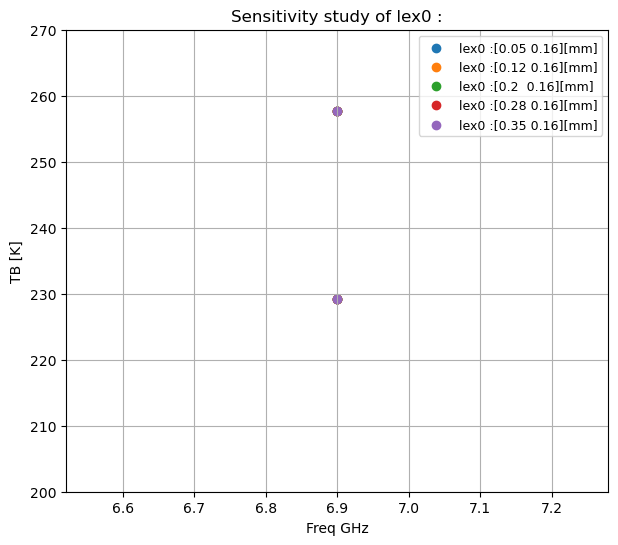

-------------------------------------------------------------
lex1 :5e-05
rv [0.06212484 0.06088174 0.05861453 0.05526993 0.05077265 0.04502946
 0.03794388 0.0294595  0.01968677 0.00929927 0.00096489 0.00618352
 0.10971789]
mu1: [ 3.56049941  8.18733111 12.87686513 17.63082175 22.47198702 27.43192362
 32.5527464  37.89295138 43.53902181 49.63006303 56.41887602 64.4693197
 75.80504879]
mu2: [ 2.13620114  4.90347296  7.68708696 10.47439331 13.26310016 16.05248465
 18.84224776 21.63224362 24.42239267 27.21264784 30.00297948 32.793368
 35.58379993]
mu1: [0.99806978 0.98980774 0.97485126 0.95302787 0.92406652 0.88755884
 0.84289645 0.78915965 0.72490539 0.64772023 0.55311711 0.43099434
 0.24522196]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94641138 0.92956917 0.91052214 0.88931545 0.8659994  0.8406293
 0.81326532]
eps1: (1.2558465956229954+0.01724856436252578j)
eps2: (3.485902483144466+0.048482768955471656j)
V---------------------
[0.93787516 0.93911826 0.941

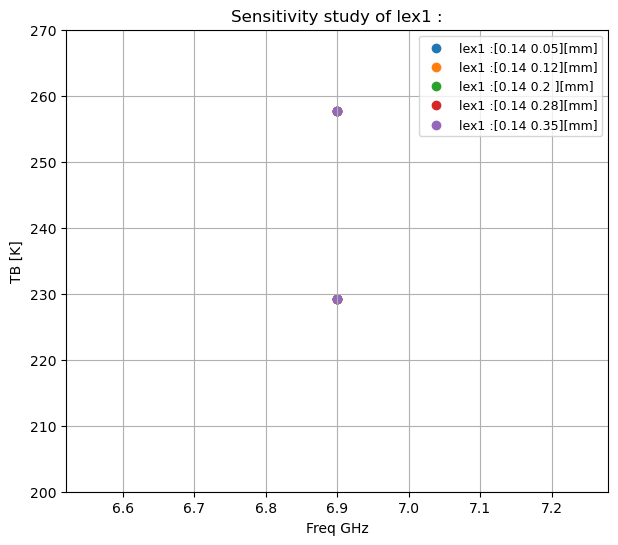

-------------------------------------------------------------
sal0 :1e-05
rv [0.06212484 0.06088174 0.05861453 0.05526993 0.05077265 0.04502946
 0.03794388 0.0294595  0.01968677 0.00929927 0.00096489 0.00618352
 0.10971789]
mu1: [ 3.56049941  8.18733111 12.87686513 17.63082175 22.47198702 27.43192362
 32.5527464  37.89295138 43.53902181 49.63006303 56.41887602 64.4693197
 75.80504879]
mu2: [ 2.13620114  4.90347296  7.68708696 10.47439331 13.26310016 16.05248465
 18.84224776 21.63224362 24.42239267 27.21264784 30.00297948 32.793368
 35.58379993]
mu1: [0.99806978 0.98980774 0.97485126 0.95302787 0.92406652 0.88755884
 0.84289645 0.78915965 0.72490539 0.64772023 0.55311711 0.43099434
 0.24522196]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94641138 0.92956917 0.91052214 0.88931545 0.8659994  0.8406293
 0.81326532]
eps1: (1.2558465956229954+0.01724856436252578j)
eps2: (3.485902483144466+0.048482768955471656j)
V---------------------
[0.93787516 0.93911826 0.941

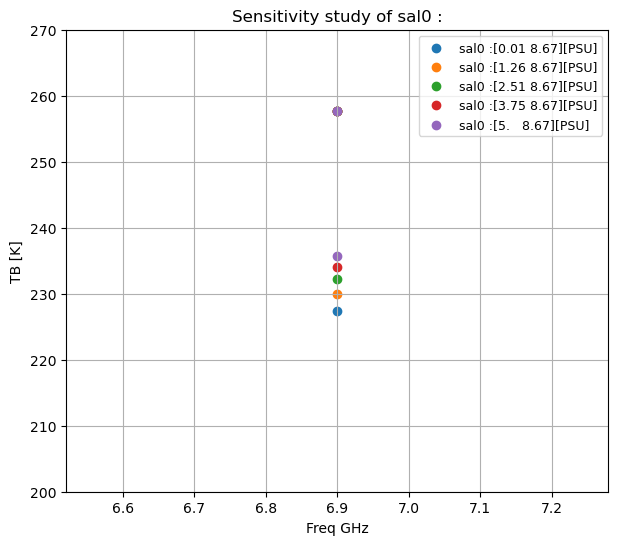

-------------------------------------------------------------
sal1 :0.001
rv [0.06589897 0.06455875 0.06211271 0.05850038 0.05363579 0.04741175
 0.03971629 0.03048342 0.01984797 0.00865279 0.00040737 0.01182435
 0.22290078]
mu1: [ 3.61780174  8.31984864 13.08747623 17.92373187 22.85343547 27.9109672
 33.14256309 38.6132101  44.42059204 50.72565093 57.83232968 66.47096401
 80.07987967]
mu2: [ 2.13608249  4.90319953  7.68665523 10.47379883 13.26233689 16.05154461
 18.84112071 21.63091668 24.42084976 27.21086894 30.00093969 32.79103621
 35.58113703]
mu1: [0.99800717 0.98947572 0.97402549 0.95146702 0.92150134 0.88367605
 0.8373128  0.78137661 0.71422118 0.63303437 0.53239872 0.39921376
 0.17227503]
mu2: [0.99930512 0.99634052 0.99101438 0.98333814 0.97332988 0.96101334
 0.94641773 0.92957771 0.91053327 0.88932965 0.8660172  0.84065134
 0.81329236]
eps1: (1.2164976715801106+0.002118748819562495j)
eps2: (3.485902483144466+0.048482768955471656j)
V---------------------
[0.93410103 0.93544125 

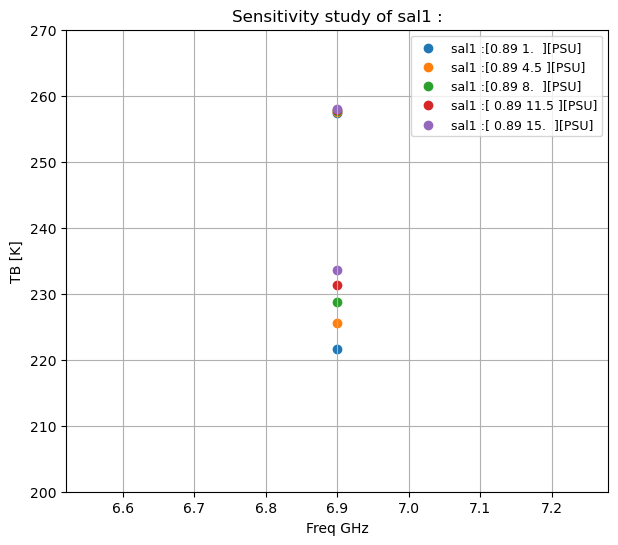

-------------------------------------------------------------
rho0 :150.0
rv [0.06212484 0.06088174 0.05861453 0.05526993 0.05077265 0.04502946
 0.03794388 0.0294595  0.01968677 0.00929927 0.00096489 0.00618352
 0.10971789]
mu1: [ 3.56049941  8.18733111 12.87686513 17.63082175 22.47198702 27.43192362
 32.5527464  37.89295138 43.53902181 49.63006303 56.41887602 64.4693197
 75.80504879]
mu2: [ 2.13620114  4.90347296  7.68708696 10.47439331 13.26310016 16.05248465
 18.84224776 21.63224362 24.42239267 27.21264784 30.00297948 32.793368
 35.58379993]
mu1: [0.99806978 0.98980774 0.97485126 0.95302787 0.92406652 0.88755884
 0.84289645 0.78915965 0.72490539 0.64772023 0.55311711 0.43099434
 0.24522196]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94641138 0.92956917 0.91052214 0.88931545 0.8659994  0.8406293
 0.81326532]
eps1: (1.2558465956229954+0.01724856436252578j)
eps2: (3.485902483144466+0.048482768955471656j)
V---------------------
[0.93787516 0.93911826 0.941

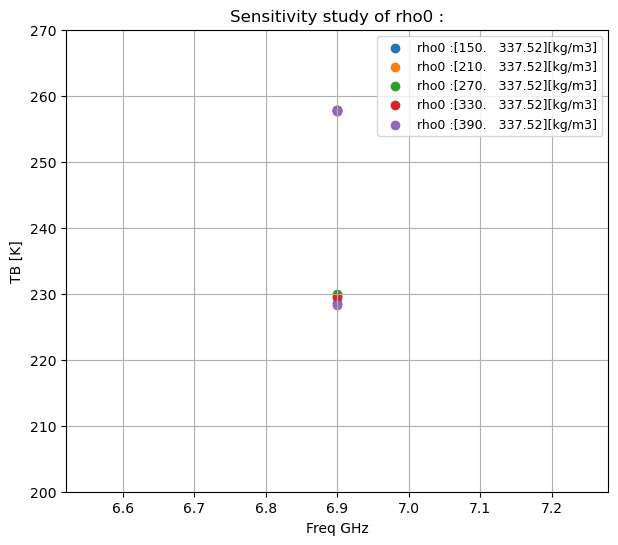

-------------------------------------------------------------
rho1 :150.0
rv [0.08429161 0.08244334 0.07905809 0.07403026 0.06720587 0.05838626
 0.04735509 0.0339854  0.01864545 0.00393346 0.00491957 0.22427576]
mu1: [ 3.89225127  8.95505769 14.09856508 19.33326671 24.6953859  30.2355862
 36.0249519  42.16989088 48.84550369 56.38353778 65.59035783 80.50786883]
mu2: [ 2.13609694  4.90323283  7.68670782 10.47387124 13.26242986 16.05165911
 18.84125799 21.63107831 24.4210377  27.21108562 30.00118815 32.79132023]
mu1: [0.99769347 0.98781074 0.96987812 0.94360889 0.90854183 0.86396221
 0.80876094 0.74115749 0.65809169 0.55363084 0.41325768 0.16491215]
mu2: [0.99930511 0.99634048 0.99101426 0.98333791 0.97332951 0.96101278
 0.94641696 0.92957667 0.91053192 0.88932792 0.86601504 0.84064866]
eps1: (1.0512142477205022+0.002634880113311005j)
eps2: (3.485902483144466+0.048482768955471656j)
V---------------------
[0.91570839 0.91755666 0.92094191 0.92596974 0.93279413 0.94161374
 0.95264491 0.9660

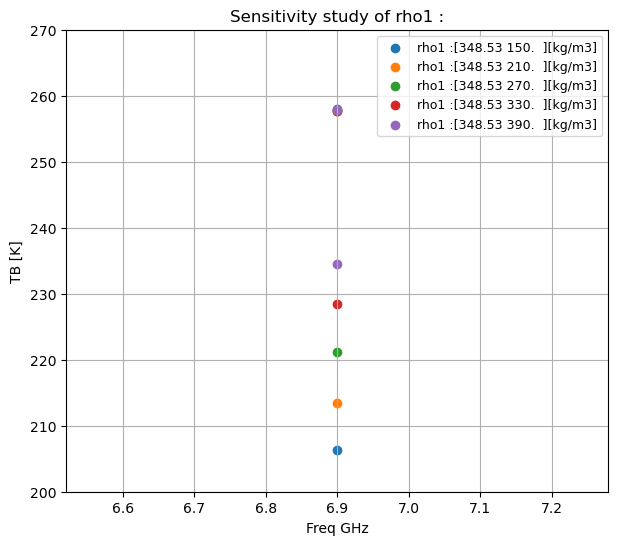

248.0837746478873
Tsur :
-------------------------------------------------------------
Tsur :248.0837746478873
rv [0.0612546  0.06003362 0.0578071  0.05452335 0.05010941 0.04447507
 0.03752722 0.02921152 0.01963349 0.00943271 0.00111467 0.00525495
 0.09494966]
mu1: [ 3.54716046  8.15648856 12.82786222 17.56270341 22.38334045 27.32070575
 32.41599991 37.72629455 43.33565095 49.37855201 56.09733986 64.02410562
 74.98092963]
mu2: [ 2.13620111  4.90347288  7.68708685 10.47439315 13.26309996 16.05248441
 18.84224746 21.63224327 24.42239227 27.21264737 30.00297894 32.79336738
 35.58379923]
mu1: [0.99808421 0.98988426 0.9750415  0.95338729 0.9246568  0.88845143
 0.84417826 0.7909428  0.72734588 0.6510584  0.55778364 0.43799297
 0.25914053]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94641138 0.92956918 0.91052214 0.88931545 0.86599941 0.84062931
 0.81326533]
eps1: (1.246631982648728+0.016222083423287265j)
eps2: (3.434499320434175+0.04378959110316494j)
V----------

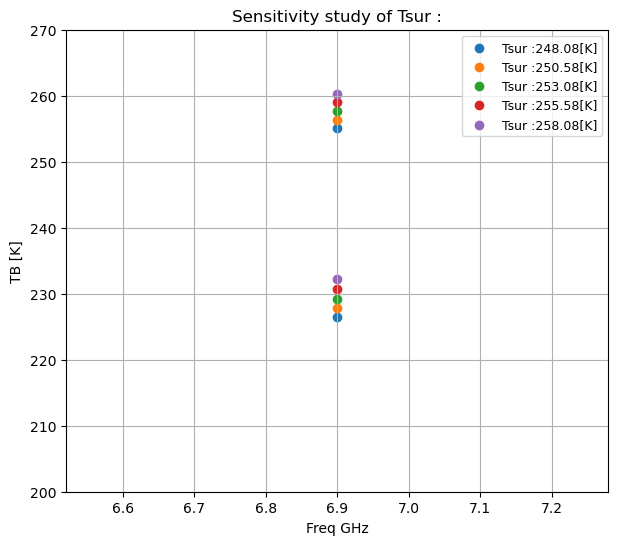

-------------------------------------------------------------
Roughness :0.05
rv [0.06212484 0.06088174 0.05861453 0.05526993 0.05077265 0.04502946
 0.03794388 0.0294595  0.01968677 0.00929927 0.00096489 0.00618352
 0.10971789]
mu1: [ 3.56049941  8.18733111 12.87686513 17.63082175 22.47198702 27.43192362
 32.5527464  37.89295138 43.53902181 49.63006303 56.41887602 64.4693197
 75.80504879]
mu2: [ 2.13620114  4.90347296  7.68708696 10.47439331 13.26310016 16.05248465
 18.84224776 21.63224362 24.42239267 27.21264784 30.00297948 32.793368
 35.58379993]
mu1: [0.99806978 0.98980774 0.97485126 0.95302787 0.92406652 0.88755884
 0.84289645 0.78915965 0.72490539 0.64772023 0.55311711 0.43099434
 0.24522196]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94641138 0.92956917 0.91052214 0.88931545 0.8659994  0.8406293
 0.81326532]
eps1: (1.2558465956229954+0.01724856436252578j)
eps2: (3.485902483144466+0.048482768955471656j)
V---------------------
[0.93787516 0.93911826 0

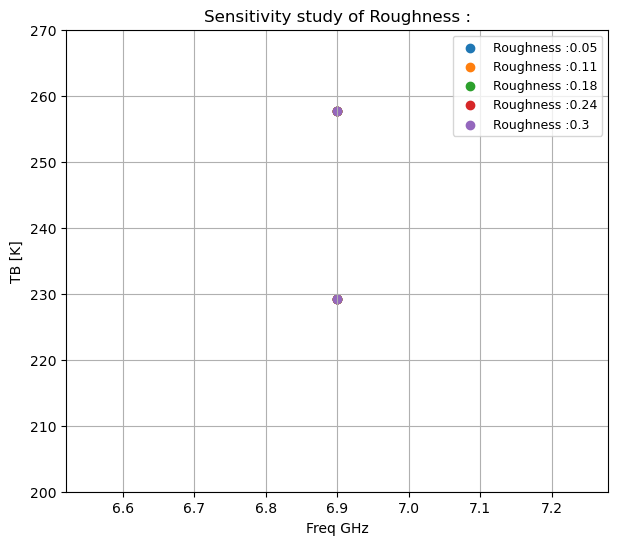

-------------------------------------------------------------
SIT :0.25
-------------------------------------------------------------
SIT :0.6875
-------------------------------------------------------------
SIT :1.125
-------------------------------------------------------------
SIT :1.5625
rv [0.06196352 0.06072454 0.05846488 0.0551316  0.05064981 0.04492686
 0.0378669  0.02941391 0.01967741 0.00932453 0.00099226 0.00600246
 0.10677892]
mu1: [ 3.55802918  8.18161924 12.86778962 17.61820507 22.45556641 27.41131889
 32.52740681 37.86206002 43.50130819 49.5833883  56.35912675 64.38632709
 75.64893794]
mu2: [ 2.13620116  4.903473    7.68708703 10.4743934  13.26310028 16.0524848
 18.84224794 21.63224383 24.42239292 27.21264812 30.0029798  32.79336836
 35.58380035]
mu1: [0.99807246 0.98982194 0.97488655 0.95309455 0.92417603 0.88772445
 0.84313434 0.78949068 0.72535865 0.64834067 0.55398559 0.43230095
 0.2478625 ]
mu2: [0.99930504 0.99634012 0.99101337 0.98333625 0.97332683 0.9610088
 0.94

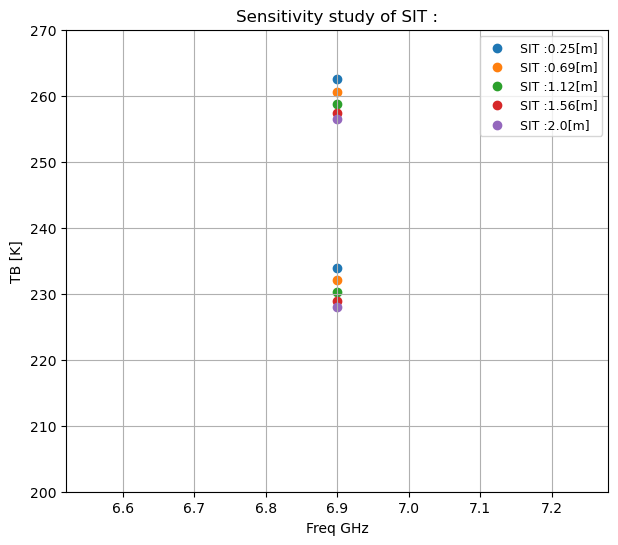

In [7]:
# savepath = "C:/Users/Ida Olsen/Documents/Speciale_2022/figures/Simulated_values_sensitivity_studies/"
nupo = 5
#DH_fraction = 0.25
SD_range = np.linspace(0.02, 0.20, nupo)
ks_range = np.linspace(0.10, 0.45, nupo)
lex_range0 = np.linspace(0.05e-3, 0.35e-3, nupo)
lex_range1 = np.linspace(0.05e-3, 0.35e-3, nupo)
sal_range0 = np.linspace(0.01*PSU, 5*PSU, nupo)
sal_range1 = np.linspace(1*PSU, 15*PSU, nupo)
rho_range0 = np.linspace(150, 390, nupo)
rho_range1 = np.linspace(150, 390, nupo)

colors = ['C' + str(i) for i in range(nupo)]
# 
# print(data.Tsur)
data = smrt_values(FYI_data)
Tsur_range = np.linspace(data.Tsur-5, data.Tsur+5, nupo)
m_range = np.linspace(0.05, 0.3, nupo)
sit_range = np.linspace(0.25, 2.0, nupo)

# ranges = [SD0_range, SD1_range,lex0_range, lex1_range, sal0_range,
#           sal1_range, rho0_range, rho1_range, Tsur_range, m_range, sit_range]
ranges = [SD_range, ks_range, lex_range0, lex_range1, sal_range0, sal_range1, rho_range0, rho_range1, Tsur_range, m_range, sit_range]

#variables = ['SD0 :', 'SD1 :', 'lex0 :', 'lex1 :', 'sal0 :',
#             'sal1 :', 'rho0 :', 'rho1 :', 'Tsur :', 'slope (m) :', 'SIT :']
variables = ['SD :','ks :', 'lex0 :', 'lex1 :', 'sal0 :', 'sal1 :', 'rho0 :', 'rho1 :', 'Tsur :', 'Roughness :', 'SIT :']
units = ['[cm]','[w/Km]', '[mm]','[mm]', '[PSU]', '[PSU]','[kg/m3]', '[kg/m3]', '[K]', '', '[m]']


sim_TBV = []
sim_TBH = []
## Plots results
for rangee, var_name, unit in zip(ranges, variables, units):
    #print(rangee)
    data = smrt_values(FYI_data)
    plt.figure(figsize=(7,6))
    frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
    freqs = [f*1e-9 for f in frequencies]
    for var, color,  in zip(rangee, colors):
        if 'SD' in var_name:
            sd0 = var
            sd1 = 0.03
            data.sd = [sd0, sd1]  
            labell = var_name + str(np.round(np.array(data.sd)*100, 2)) + unit
        if 'ks' in var_name:
            data.ks = var   
            labell = var_name + str(np.round(np.array(data.ks), 2)) + unit
        if 'lex0' in var_name:
            data.lex[0] = var
            labell = var_name + str(np.round(np.array(data.lex)*1e3, 2)) + unit
        elif 'lex1' in var_name:
            data.lex[1] = var
            labell = var_name + str(np.round(np.array(data.lex)*1e3, 2)) + unit
        elif 'sal0' in var_name:
            data.sal[0] = var
            labell = var_name + str(np.round(np.array(data.sal)*1e3, 2)) + unit
        elif 'sal1' in var_name:
            data.sal[1] = var
            labell = var_name + str(np.round(np.array(data.sal)*1e3, 2)) + unit
        elif 'rho0' in var_name:
            data.rho[0] = var
            labell = var_name + str(np.round(np.array(data.rho), 2)) + unit
        elif 'rho1' in var_name:
            data.rho[1] = var
            labell = var_name + str(np.round(np.array(data.rho), 2)) + unit
        elif 'Tsur' in var_name:
            print(var)
            print(var_name)
            data.Tsur = var
            labell = var_name + str(np.round(np.array(data.Tsur), 2)) + unit
        elif 'Rough' in var_name:
            data.m = var
            labell = var_name + str(np.round(np.array(data.m), 2)) + unit
        elif 'SIT' in var_name:
            data.sit = var
            labell = var_name + str(np.round(np.array(data.sit), 2)) + unit
        print('-------------------------------------------------------------')
        print(var_name + str(var))
        data.calc_temp(plot=False)
        TBV, TBH = SMRT_simulation(data)
        y = TBV
        freqs = [6.9]
        plt.scatter(freqs, y, c=color, linewidth=1, label = labell)
        y = TBH
        plt.scatter(freqs, y, c=color,linewidth=1)

    #y = FYI_OIB_SIM[:5]
    #plt.plot(freqs, y, c='k', linewidth=2, label = 'TBV Avg. Sim.')
    #y = FYI_OIB_SIM[5:]
    #plt.plot(freqs,y, c='k', linewidth=2, label = 'TBH Avg. Sim.')
    plt.grid()
    plt.ylim([200,270])
    plt.legend(loc="best", fontsize=9) #bbox_to_anchor=(1, 0.8))
    plt.xlabel('Freq GHz')
    plt.ylabel('TB [K]')
    plt.title('Sensitivity study of ' + var_name)
    # plt.savefig(savepath + (var_name).replace(' :', '') + '.png', bbox_inches='tight')
    plt.show()

OE values

In [14]:
## Iterate over different start guesses
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=3)
print(x_ap)



forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": 3, "n": 0, 
                 "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,x_truth=x_truth
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=15)
print('-----------------')
print('TRUE VALUES')
print('-----------------')
print('SD: ', np.mean(FYI_data.sd, axis=0))
print('lex: ',np.mean(FYI_data.sd_lex)*1e3)
print('rho: ',np.mean(FYI_data.sd_rho, axis=0))
print('sal: ',np.mean(FYI_data.sd_sal, axis=0)*1e3)
print('SIT: ',np.mean(FYI_data.sit))

print('-----------------')
print(oe.x_op)
print(10**(oe.x_op[:1])*1e2)
#try:
#    print(10**(oe.x_op[1:2])*1e3)
#except:
#    pass
#print((oe.x_op[2]))
print('-----------------')
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])
oe.plotIterations()

NameError: name 'x_vars' is not defined